In [1]:
from omegaconf import DictConfig, OmegaConf

import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from src import data_loader, train, test, plotting, submissions, unet

cfg = OmegaConf.load("config.yaml")

print(OmegaConf.to_yaml(cfg))

# ===== Torch config =====
device = cfg.device
torch.manual_seed(cfg.seed)
torch.set_default_dtype(getattr(torch, cfg.tensor_dtype))

# ===== Data Loading =====
train_loader, test_loader = data_loader.get_loader(cfg)

# ===== Model, Optimizer and Loss function =====
model = unet.UNet()
model = model.to(device=device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=cfg.training.lr, weight_decay=cfg.training.weight_decay
)
loss_fn = torch.nn.functional.binary_cross_entropy

device: cpu
data_path: ./data
seed: 42
tensor_dtype: float32
training:
  epochs: 20
  batch_size: 10
  lr: 0.001
  weight_decay: 0.0001



## Model training ##

In [2]:
train_losses, train_accs = train.train_model(
    model,
    optimizer,
    loss_fn,
    train_loader,
    cfg,
)

100%|██████████| 8/8 [03:42<00:00, 27.75s/it]


Train Epoch: 1: loss=6.38e-01, f1=0.403


100%|██████████| 8/8 [03:44<00:00, 28.09s/it]


Train Epoch: 2: loss=5.02e-01, f1=0.460


100%|██████████| 8/8 [03:46<00:00, 28.36s/it]


Train Epoch: 3: loss=4.43e-01, f1=0.510


100%|██████████| 8/8 [03:46<00:00, 28.25s/it]


Train Epoch: 4: loss=3.99e-01, f1=0.587


100%|██████████| 8/8 [03:44<00:00, 28.07s/it]


Train Epoch: 5: loss=3.68e-01, f1=0.622


100%|██████████| 8/8 [03:39<00:00, 27.48s/it]


Train Epoch: 6: loss=3.59e-01, f1=0.617


100%|██████████| 8/8 [03:37<00:00, 27.16s/it]


Train Epoch: 7: loss=3.21e-01, f1=0.655


100%|██████████| 8/8 [03:38<00:00, 27.25s/it]


Train Epoch: 8: loss=3.05e-01, f1=0.691


100%|██████████| 8/8 [03:36<00:00, 27.11s/it]


Train Epoch: 9: loss=3.00e-01, f1=0.640


100%|██████████| 8/8 [03:43<00:00, 27.91s/it]


Train Epoch: 10: loss=2.89e-01, f1=0.673


100%|██████████| 8/8 [03:42<00:00, 27.77s/it]


Train Epoch: 11: loss=2.71e-01, f1=0.681


100%|██████████| 8/8 [03:41<00:00, 27.71s/it]


Train Epoch: 12: loss=2.49e-01, f1=0.709


100%|██████████| 8/8 [03:42<00:00, 27.79s/it]


Train Epoch: 13: loss=2.33e-01, f1=0.737


100%|██████████| 8/8 [03:42<00:00, 27.81s/it]


Train Epoch: 14: loss=2.21e-01, f1=0.769


100%|██████████| 8/8 [03:45<00:00, 28.19s/it]


Train Epoch: 15: loss=2.19e-01, f1=0.753


100%|██████████| 8/8 [03:45<00:00, 28.19s/it]


Train Epoch: 16: loss=2.10e-01, f1=0.778


100%|██████████| 8/8 [03:39<00:00, 27.44s/it]


Train Epoch: 17: loss=2.18e-01, f1=0.760


100%|██████████| 8/8 [03:45<00:00, 28.18s/it]


Train Epoch: 18: loss=1.92e-01, f1=0.782


100%|██████████| 8/8 [03:53<00:00, 29.22s/it]


Train Epoch: 19: loss=1.93e-01, f1=0.811


100%|██████████| 8/8 [03:47<00:00, 28.50s/it]

Train Epoch: 20: loss=1.81e-01, f1=0.811


## Model testing ##

In [23]:
test_losses, test_accuracies = test.test_model(
    model,
    device,
    test_loader,
    loss_fn=partial(loss_fn, reduction="none"),
)

## Predictions ##

In [4]:
predictions = submissions.get_predictions(model, test_loader, cfg)

## Plotting of predictions ##

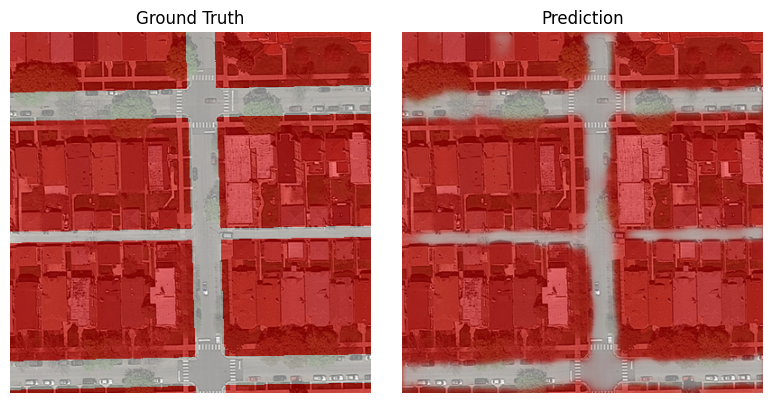

In [28]:
indice = 1

plotting.plot_pred_on(test_loader, predictions, indice, cfg)

## Make submissions ##

In [24]:
patched_preds = submissions.make_submission(predictions, cfg)

## Plotting of patched predicitons ##

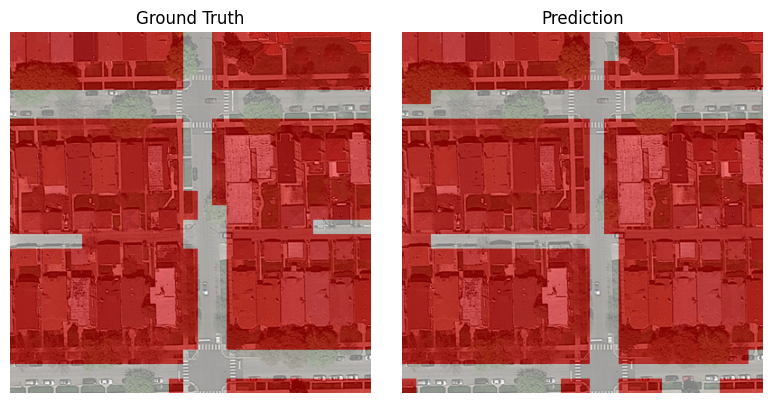

In [27]:
from src import utils
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSC

def plot_pred_on(test_loader, predictions, indice, cfg, gt_patch=None):
    # Set the figure size based on the number of samples
    _, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Get the prediction
    pred = predictions[indice]

    # Get the sample using the generated index
    image, groundtruth = test_loader.dataset[indice]

    # Scale the prediction to the size of the image
    if pred.shape[0] != image.shape[1] or pred.shape[1] != image.shape[2]:
        pred = utils.bigger_image(pred, cfg, patch_size=int(image.shape[1] / pred.shape[0]))
    
    # Patch the groundtruth if specified
    if gt_patch is not None:
        groundtruth = utils.smaller_image(groundtruth, gt_patch)
        for i, line in enumerate(groundtruth):
            for j, point in enumerate(line):
                point_gt = 1 if point > 0.5 else 0
                groundtruth[i][j] = point_gt
        groundtruth = utils.bigger_image(groundtruth, cfg, gt_patch)

    # Create a red-to-white colormap
    cmap = LSC.from_list("red_to_white", ["red", "white"])

    # Plot the original image
    axes[0].imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
    axes[0].imshow(groundtruth, cmap=cmap, alpha=0.5)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    # Plot the ground truth
    axes[1].imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
    axes[1].imshow(pred, cmap=cmap, alpha=0.5)
    axes[1].set_title("Prediction")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

plot_pred_on(test_loader, patched_preds, indice, cfg, 16)